# Preparation

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, wilcoxon, ranksums
from itertools import combinations

In [ ]:
# Read RawData.csv and GroundTruth.csv
raw_data = pd.read_csv('RawData.csv')
ground_truth = pd.read_csv('GroundTruth.csv')

# Define mapping functions
def map_java_experience(value):
    mapping = {
        'No experience': 0,
        'As part of University projects': 1,
        'Developed several projects using Java': 2,
        'Developed project(s) using Java outside University': 3,
        'Several years of professional experience with Java': 4
    }
    return mapping.get(value, 0)

def map_familiarity(value):
    mapping = {
        'Strongly disagree': 0,
        'Disagree': 1,
        'Neither-Agree-nor-Disagree': 2,
        'Agree': 3,
        'Strongly agree': 4
    }
    return mapping.get(value, 0)

def map_vuln_experience(value):
    mapping = {
        'No experience': 0,
        'As part of University projects': 1,
        'Find vulnerabilities outside university': 2,
        'Find vulnerabilities for several projects': 3,
        'Several years of professional experience outside of university': 4
    }
    return mapping.get(value, 0)

def map_difficulty(value):
    mapping = {
        'Strongly disagree': 0,
        'Disagree': 1,
        'Neither-Agree-nor-Disagree': 2,
        'Agree': 3,
        'Strongly agree': 4,
        'Very Hard': 0,
        'Hard': 1,
        'Neither Hard Nor Easy': 2,
        'Easy': 3,
        'Very Easy': 4,
        '0-20%': 0,
        '20-40%': 1,
        '40-60%': 2,
        '60-80%': 3,
        '80%-100%': 4
    }
    return mapping.get(value, 0)

# Initialize a new DataFrame
new_data = pd.DataFrame(columns=['ID', 'Groups', 'Tasks', 'Acc', 'Eff', 'Java', 'Vulns', 'Perc'])

# Iterate through each row in RawData
for index, row in raw_data.iterrows():
    response_id = row['ResponseId']
    group = str(row['Which Group']).replace('Group', '') if pd.notna(row['Which Group']) else ''
    duration = row['Duration (in seconds)']
    
    # Get the correct answers from Ground Truth
    gt_row = ground_truth[ground_truth['Group'] == f'Group {group}']
    if not gt_row.empty:
        gt_path = set(gt_row['Path'].values[0].split(';'))
        gt_injection = set(gt_row['Injection'].values[0].split(';'))
        gt_xss = set(gt_row['XSS'].values[0].split(';'))
        gt_dos = set(gt_row['DoS'].values[0].split(';'))
    else:
        gt_path = set()
        gt_injection = set()
        gt_xss = set()
        gt_dos = set()
    
    # Process Java and Vulns
    java_experience = map_java_experience(row['WorkingJava'])
    java_familiarity = map_familiarity(row['Familiar.Java'])
    java_value = round((java_experience + java_familiarity) / 2, 5)  # Round to 5 decimal places
    
    vuln_experience = map_vuln_experience(row['FindingVulns'])
    vuln_familiarity = map_familiarity(row['Familiar.Vuln'])
    vuln_value = round((vuln_experience + vuln_familiarity) / 2, 5)  # Round to 5 decimal places
    
    # Process Tasks
    tasks = ['Path', 'Injection', 'XSS', 'DoS']
    task_columns = ['PathLines', 'InjectionLines', 'XSSLines', 'DoSLines']
    difficulty_columns = ['Difficulty.Marks_1', 'Difficulty.Marks_2', 'Difficulty.Marks_3', 'Difficulty.Marks_4']
    correct_columns = ['Difficulty.Correct_1', 'Difficulty.Correct_2', 'Difficulty.Correct_3', 'Difficulty.Correct_4']
    
    for i, task in enumerate(tasks):
        task_lines = set(str(row[task_columns[i]]).split(';')) if pd.notna(row[task_columns[i]]) else set()
        gt_lines = gt_path if task == 'Path' else gt_injection if task == 'Injection' else gt_xss if task == 'XSS' else gt_dos
        
        # Calculate Acc
        correct_lines = task_lines.intersection(gt_lines)
        acc = round(len(correct_lines) / len(gt_lines), 5) if len(gt_lines) > 0 else 0  # Round to 5 decimal places
        
        # Calculate Eff
        eff = round((len(correct_lines) / duration) * 100, 5) if duration > 0 else 0  # Round to 5 decimal places
        
        # Calculate Perc
        difficulty = map_difficulty(row[difficulty_columns[i]])
        correct = map_difficulty(row[correct_columns[i]])
        understand = map_difficulty(row['Process.Understand'])
        time = map_difficulty(row['Process.Time'])
        training = map_difficulty(row['Process.Training'])
        perc = round(np.mean([difficulty, correct, understand, time, training]), 5)  # Round to 5 decimal places
        
        # Add to the new DataFrame
        new_row = {
            'ID': response_id,
            'Groups': group,
            'Tasks': task,
            'Acc': acc,
            'Eff': eff,
            'Java': java_value,
            'Vulns': vuln_value,
            'Perc': perc
        }
        new_row_df = pd.DataFrame([new_row]).dropna(how='all')

        # Exclude empty or all-NA entries
        if not new_row_df.empty:
            new_data = pd.concat([new_data, new_row_df], ignore_index=True)

# Save as a new CSV file
new_data.to_csv('DataSet.csv', index=False)

print('Data processing completed!')

In [2]:
# Read the data into a DataFrame
df = pd.read_csv('DataSet.csv')

# Demographic Analysis

## Histograms
Distributions of data (based on groups/ scenario)

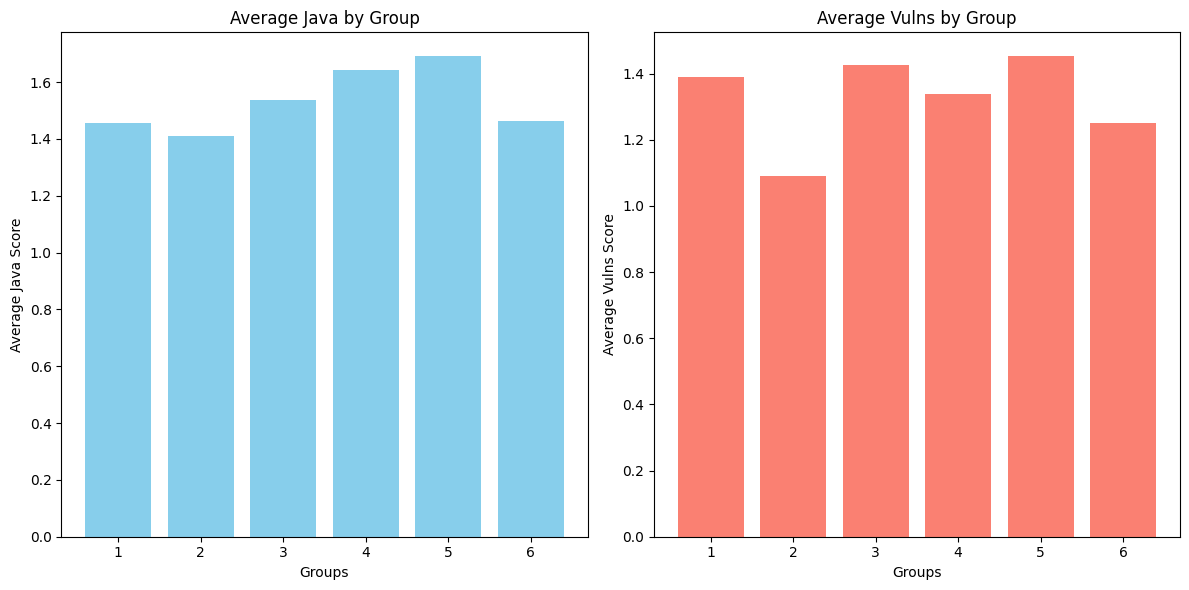

In [3]:
# Assuming df is your DataFrame containing the data
# Group by "Groups" and calculate the average values for Java and Vulns
grouped = df.groupby("Groups", as_index=False)[["Java", "Vulns"]].mean()

# Sort the grouped results alphabetically by "Groups" (if necessary)
grouped = grouped.sort_values(by="Groups")

# Create a canvas and subplots: one row, two columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Left plot: Average Java by Group
axes[0].bar(grouped["Groups"], grouped["Java"], color="skyblue")
axes[0].set_title("Average Java by Group")
axes[0].set_xlabel("Groups")
axes[0].set_ylabel("Average Java Score")

# Right plot: Average Vulns by Group
axes[1].bar(grouped["Groups"], grouped["Vulns"], color="salmon")
axes[1].set_title("Average Vulns by Group")
axes[1].set_xlabel("Groups")
axes[1].set_ylabel("Average Vulns Score")

plt.tight_layout()
plt.show()

## Scatter plots
Represent values for two different numeric variables to compare the two variables.

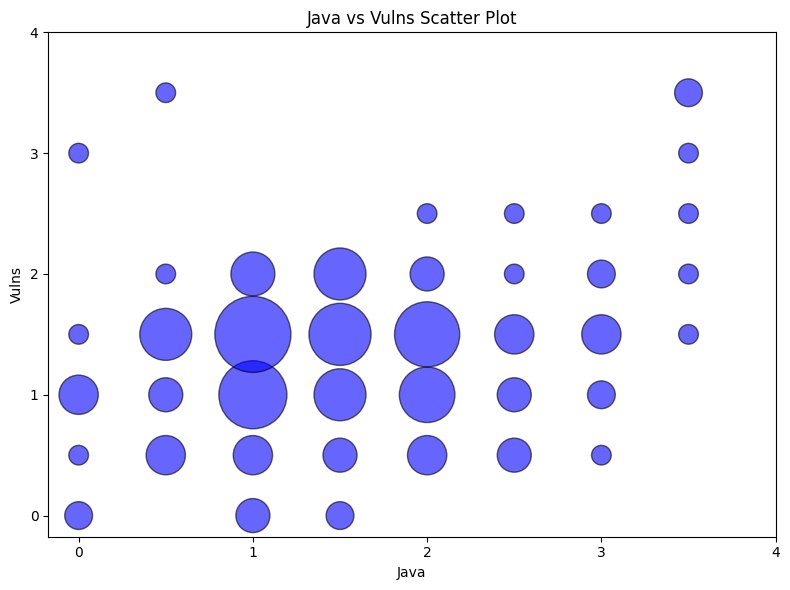

In [4]:
# Assuming df is your DataFrame containing the data
# Set global minimum and maximum values for Java and Vulns
MIN_JAVA, MAX_JAVA = df["Java"].min(), df["Java"].max()
MIN_VULNS, MAX_VULNS = df["Vulns"].min(), df["Vulns"].max()

# Define the plotting function
def java_vulns_scatter_plot(ax, data, java_col, vulns_col):
    # Count the occurrences of each point
    unique_points, counts = np.unique(np.c_[data[java_col], data[vulns_col]], return_counts=True, axis=0)
    
    # Plot the scatter plot, with point size determined by the count
    ax.scatter(
        unique_points[:, 0],  # X-axis: Java
        unique_points[:, 1],  # Y-axis: Vulns
        s=counts * 50,        # Point size related to frequency
        c="blue",             # Fixed point color is blue
        alpha=0.6,            # Transparency
        edgecolors="black"    # Black border
    )
    
    # Set the ticks for the x and y axes
    ax.set_xticks(np.arange(MIN_JAVA, MAX_JAVA + 1, 1))  # X-axis ticks for Java
    ax.set_yticks(np.arange(MIN_VULNS, MAX_VULNS + 1, 1))  # Y-axis ticks for Vulns
    
    # Set axis labels and title
    ax.set_xlabel(java_col)
    ax.set_ylabel(vulns_col)
    ax.set_title("Java vs Vulns Scatter Plot")
    
    return ax

# Create the canvas
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# Call the plotting function
java_vulns_scatter_plot(ax, df, "Java", "Vulns")

# Display the chart
plt.tight_layout()
plt.show()

# Intervention Metrics

## Boxplots
A standardized way of displaying the dataset based on the five-number summary: the minimum, the maximum, the sample median, and the first and third quartiles.

### Intervention Boxplot by Group

[5. 2. 1. 3. 4. 6.]


C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\3211212679.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Groups', y='Acc', data=df, ax=axes[0], palette=GROUP_COLORS)
C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\3211212679.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Groups', y='Eff', data=df, ax=axes[1], palette=GROUP_COLORS)


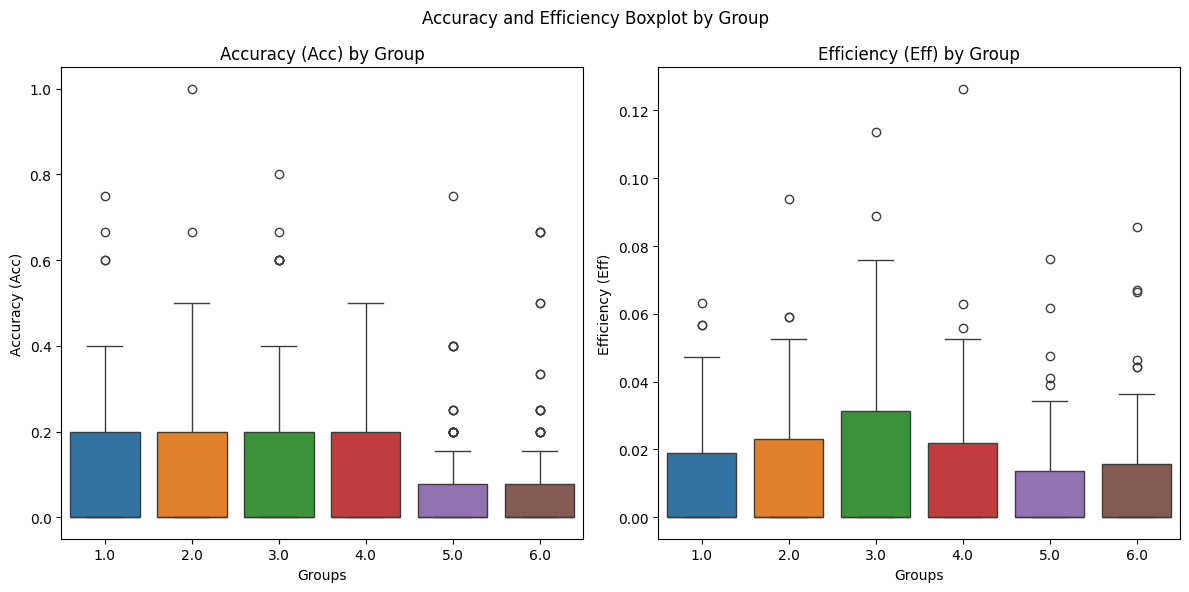

In [14]:
# Assuming df is your DataFrame containing the data
# Check the type of values in df["Groups"]
print(df["Groups"].unique())  # Output: [5.0, 2.0, 1.0, 3.0, 4.0, 6.0, nan]

# Set group colors (optional)
# Since seaborn converts group values to strings, we use strings as keys
GROUP_COLORS = {str(group): color for group, color in zip([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], sns.color_palette("tab10", 6))}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Left plot: Boxplot of Acc by Group
sns.boxplot(x='Groups', y='Acc', data=df, ax=axes[0], palette=GROUP_COLORS)
axes[0].set_title("Accuracy (Acc) by Group")
axes[0].set_xlabel("Groups")
axes[0].set_ylabel("Accuracy (Acc)")

# Right plot: Boxplot of Eff by Group
sns.boxplot(x='Groups', y='Eff', data=df, ax=axes[1], palette=GROUP_COLORS)
axes[1].set_title("Efficiency (Eff) by Group")
axes[1].set_xlabel("Groups")
axes[1].set_ylabel("Efficiency (Eff)")

# Set overall title
fig.suptitle("Accuracy and Efficiency Boxplot by Group")

# Adjust layout
plt.tight_layout()
plt.show()

### Intervention Boxplot by Scenario

C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\2562402975.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tasks', y='Acc', data=df, ax=axes[0], palette="Set2")
C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\2562402975.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tasks', y='Eff', data=df, ax=axes[1], palette="Set2")


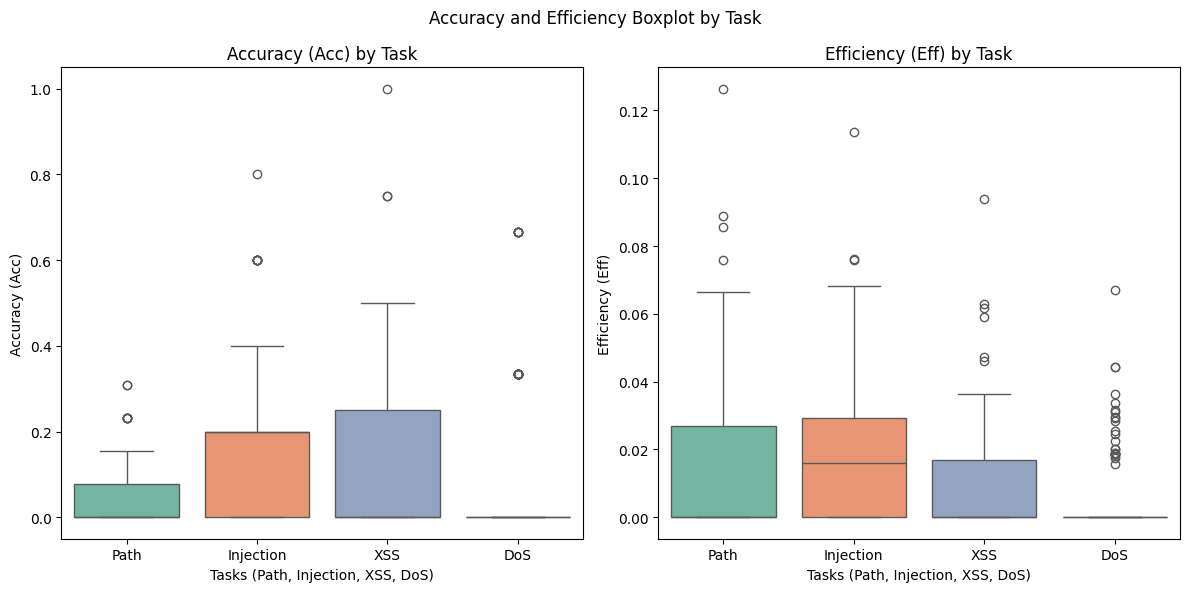

In [15]:
# Assuming df is your DataFrame containing the data
# Ensure Tasks includes all categories (including missing tasks if necessary)
expected_tasks = ["Path", "Injection", "XSS", "DoS"]

# Add a row with empty values to include missing tasks (if any)
for task in expected_tasks:
    if task not in df["Tasks"].unique():
        placeholder = pd.DataFrame({
            "Tasks": [task],
            "Acc": [None],
            "Eff": [None]
        })
        df = pd.concat([df, placeholder], ignore_index=True)

# Ensure the category order of the Tasks column
df["Tasks"] = pd.Categorical(df["Tasks"], categories=expected_tasks, ordered=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Set the color palette
sns.set_palette("muted")

# Left plot: Boxplot of Acc by Tasks
sns.boxplot(x='Tasks', y='Acc', data=df, ax=axes[0], palette="Set2")
axes[0].set_title("Accuracy (Acc) by Task")
axes[0].set_xlabel("Tasks (Path, Injection, XSS, DoS)")
axes[0].set_ylabel("Accuracy (Acc)")

# Right plot: Boxplot of Eff by Tasks
sns.boxplot(x='Tasks', y='Eff', data=df, ax=axes[1], palette="Set2")
axes[1].set_title("Efficiency (Eff) by Task")
axes[1].set_xlabel("Tasks (Path, Injection, XSS, DoS)")
axes[1].set_ylabel("Efficiency (Eff)")

# Set the overall title
fig.suptitle("Accuracy and Efficiency Boxplot by Task")

# Adjust layout
plt.tight_layout()
plt.show()

## Scatter plot

### Intervention Scatter Plot by Group

C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\94846343.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


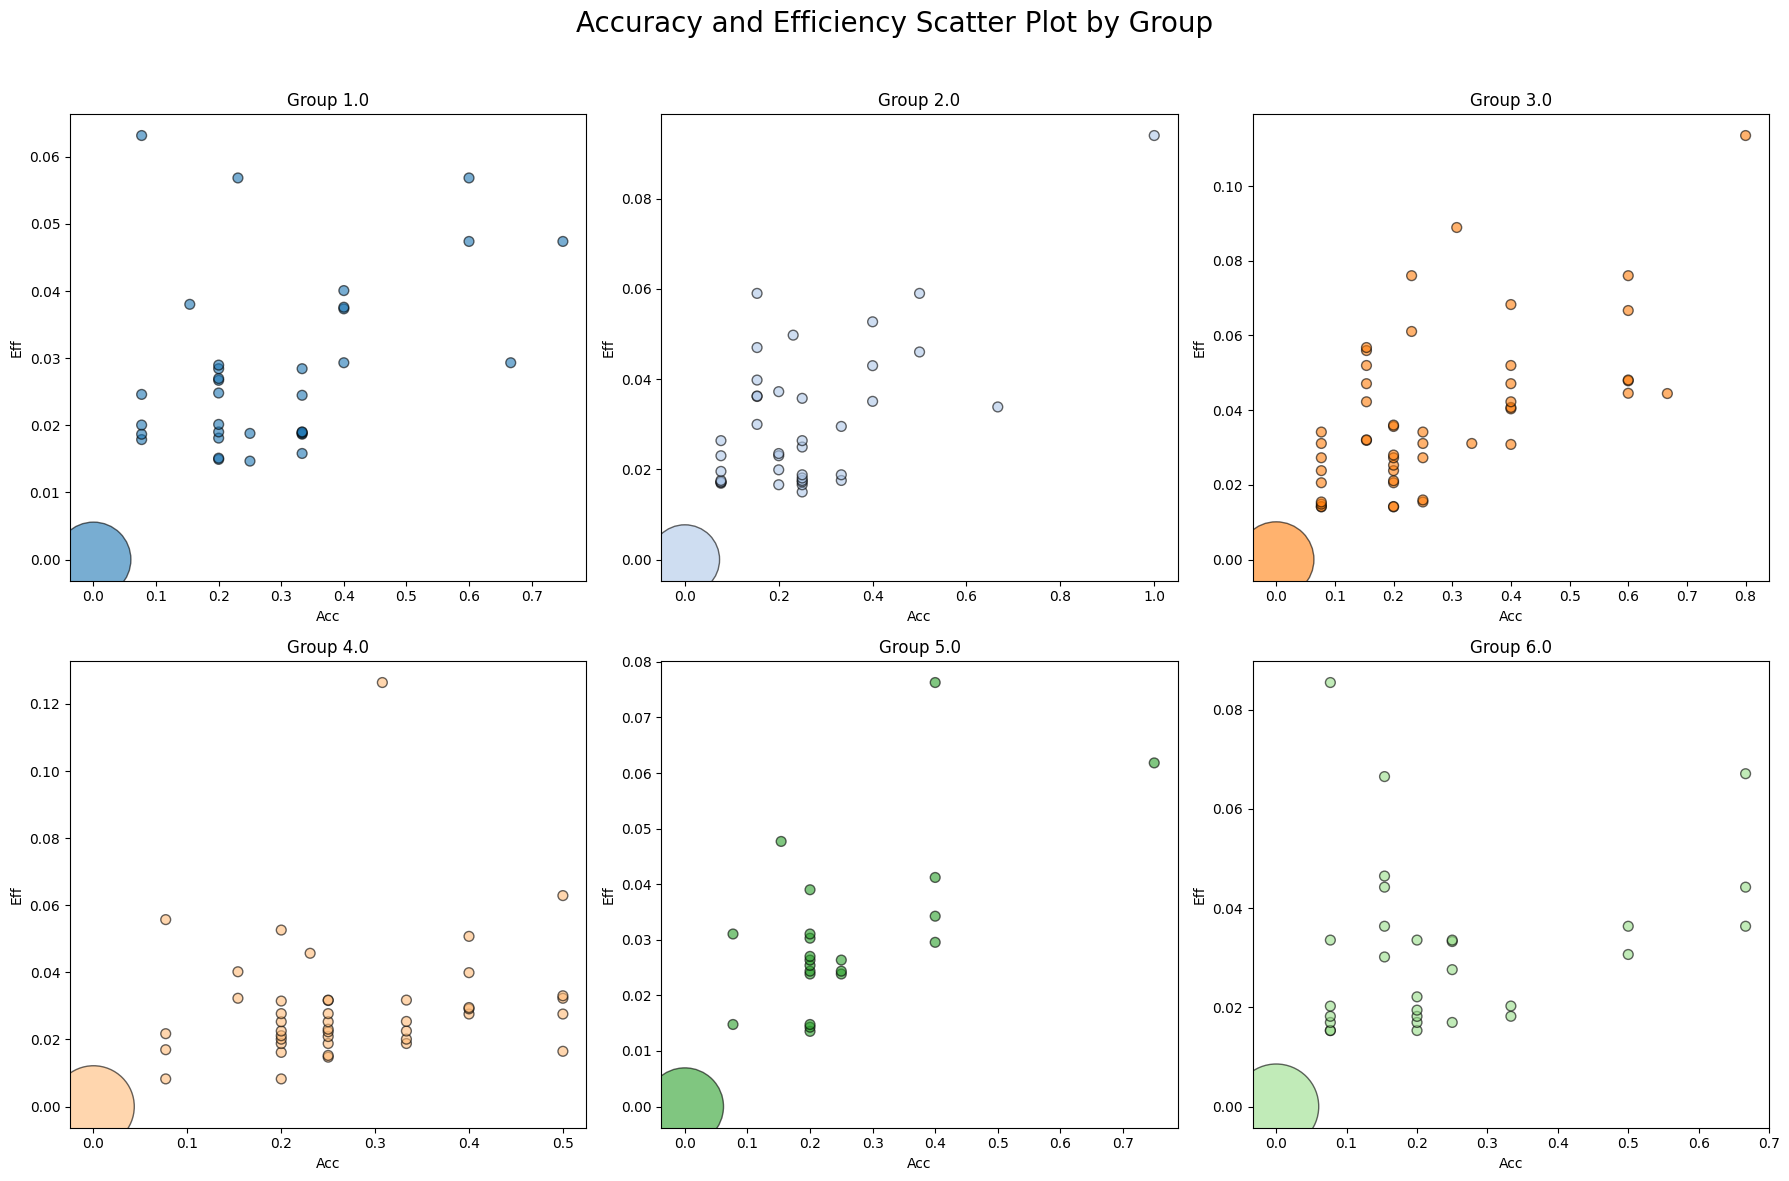

In [16]:
# Assuming df is your DataFrame containing the data
# Ensure the columns are numeric
df["Acc"] = pd.to_numeric(df["Acc"], errors='coerce')
df["Eff"] = pd.to_numeric(df["Eff"], errors='coerce')

# Define color mapping for groups
# Assuming groups are 1.0, 2.0, 3.0, 4.0, 5.0, 6.0
groups = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
GROUP_COLORS = {group: color for group, color in zip(groups, plt.cm.tab20.colors)}

# Define scatter_plot function
def scatter_plot(ax, data, group, groupVal, colors, first, second):
    # Filter data for the current group
    data_scatter = data[data[group] == groupVal]
    color = colors.get(groupVal, "blue")  # Default to blue if the group color is not defined

    # Count unique points and their occurrences
    unique_points, counts = np.unique(
        np.c_[data_scatter[first], data_scatter[second]],
        return_counts=True,
        axis=0
    )

    # Plot scatter plot
    ax.scatter(
        unique_points[:, 0],  # X-axis
        unique_points[:, 1],  # Y-axis
        s=counts * 50,        # Size of points related to frequency
        c=color,              # Color of points
        alpha=0.6,            # Transparency
        edgecolors="black"    # Black border
    )
    
    # Set axis labels and title
    ax.set_title(f"Group {groupVal}")
    ax.set_xlabel(first)
    ax.set_ylabel(second)

    return ax

# Create canvas and subplots: two rows, three columns, total 6 subplots (for 6 groups)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=100)
axes = axes.flatten()  # Flatten the 2x3 array to a 1D array

# Plot scatter plots for each group
for i, group in enumerate(groups):
    scatter_plot(axes[i], df, "Groups", group, GROUP_COLORS, "Acc", "Eff")

# Adjust layout and overall title
fig.suptitle("Accuracy and Efficiency Scatter Plot by Group", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

# Perception Metric

## Histograms

### Perception Histogram

C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\3416917200.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby("Groups")["Perc"].count().reset_index()


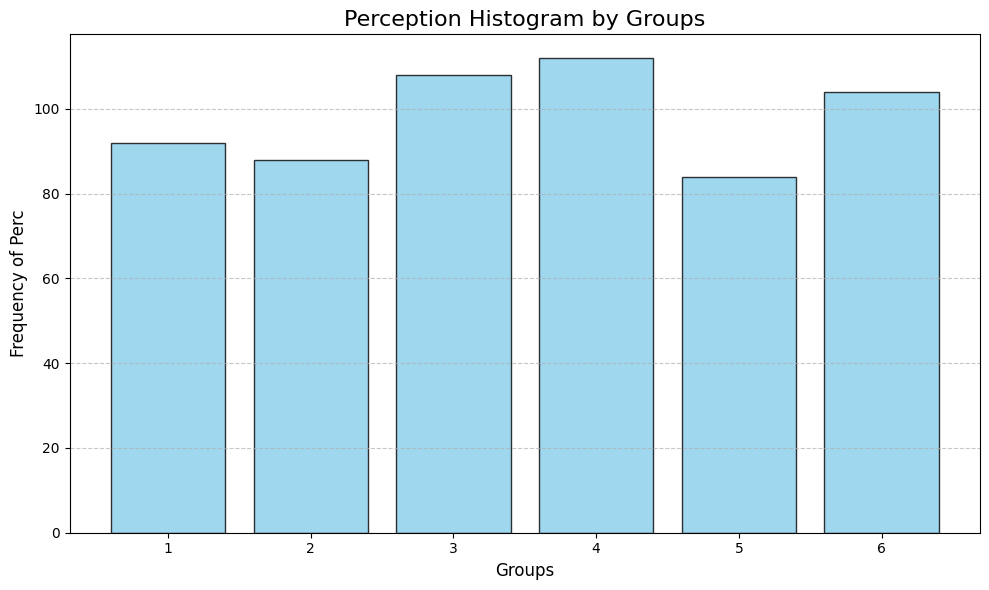

In [17]:
# Assuming df is your DataFrame containing the data
# Ensure the Groups column is ordered from 1.0 to 6.0
df["Groups"] = pd.Categorical(df["Groups"], categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=True)

# Group by Groups and count the number of Perc in each group
grouped_data = df.groupby("Groups")["Perc"].count().reset_index()
grouped_data.columns = ["Groups", "Count"]  # Rename columns

# Set up the canvas
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.bar(grouped_data["Groups"], grouped_data["Count"], color="skyblue", edgecolor="black", alpha=0.8)

# Set the title and axis labels
plt.title("Perception Histogram by Groups", fontsize=16)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Frequency of Perc", fontsize=12)

# Show grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

## Boxplots

### Perception Boxplot by Group

C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\158153072.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Groups', y='Perc', data=df, ax=ax, palette=GROUP_COLORS)


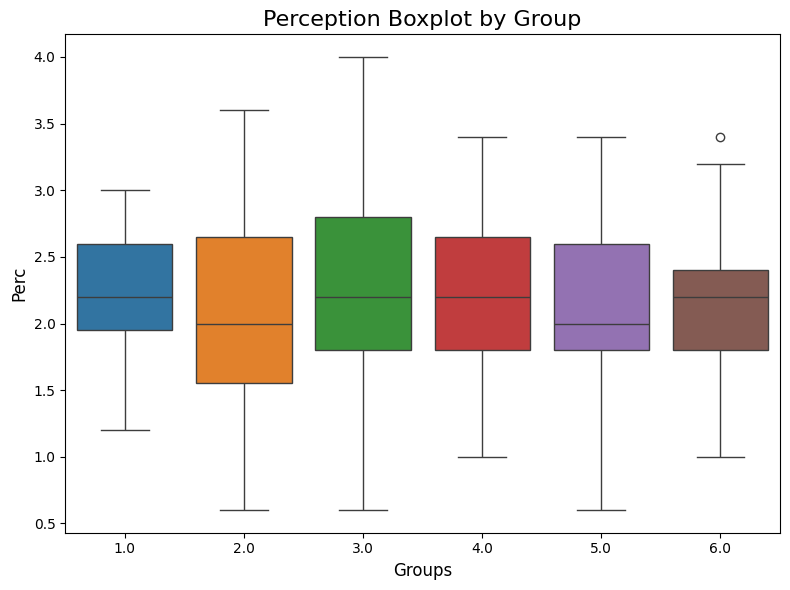

In [19]:
# Assuming df is your DataFrame containing the data
# Set category order, ensuring Groups are in 1.0~6.0 order
df["Groups"] = pd.Categorical(df["Groups"], categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=True)

# Define color mapping
# Since seaborn converts group values to strings, we use strings as keys
GROUP_COLORS = {str(group): color for group, color in zip([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], sns.color_palette("tab10", 6))}

# Create canvas
fig, ax = plt.subplots(figsize=(8, 6))

# Plot boxplot
sns.boxplot(x='Groups', y='Perc', data=df, ax=ax, palette=GROUP_COLORS)

# Set title and axis labels
ax.set_title("Perception Boxplot by Group", fontsize=16)
ax.set_xlabel("Groups", fontsize=12)
ax.set_ylabel("Perc", fontsize=12)

# Display chart
plt.tight_layout()
plt.show()

### Perception Boxplot by Scenario

C:\Users\lizel\AppData\Local\Temp\ipykernel_17240\3424409395.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Tasks", y="Perc", data=df, palette=TASK_COLORS, ax=ax)


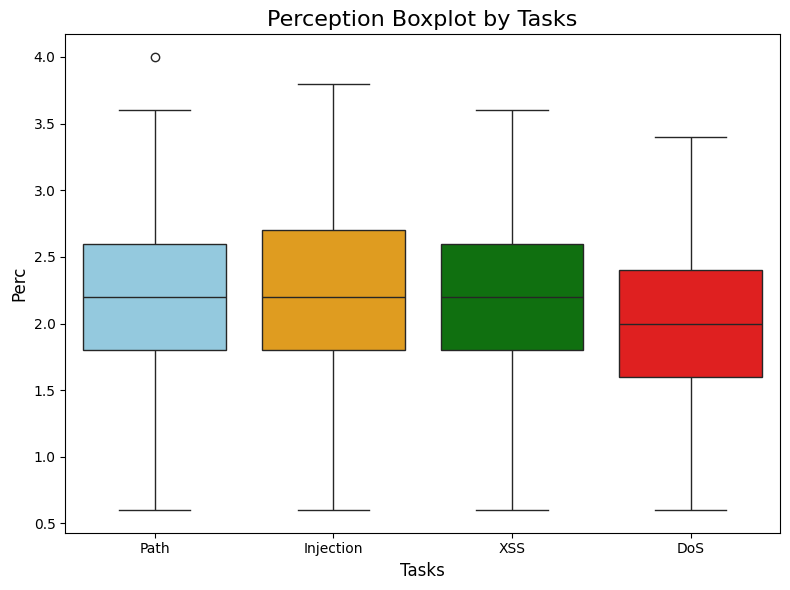

In [20]:
# Assuming df is your DataFrame containing the data
# Define color mapping for tasks
TASK_COLORS = {"Path": "skyblue", "Injection": "orange", "XSS": "green", "DoS": "red"}

# Ensure the category order of the Tasks column (if needed)
df["Tasks"] = pd.Categorical(df["Tasks"], categories=["Path", "Injection", "XSS", "DoS"], ordered=True)

# Create the canvas
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the boxplot and specify colors
sns.boxplot(x="Tasks", y="Perc", data=df, palette=TASK_COLORS, ax=ax)

# Set the title and axis labels
ax.set_title("Perception Boxplot by Tasks", fontsize=16)
ax.set_xlabel("Tasks", fontsize=12)
ax.set_ylabel("Perc", fontsize=12)

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

# Statistical Test

# Analyze zero vs non-zero with Chi-square and Wilcoxon

In case your metrics determine an excess of zeros we need to split the analysis in two test:


1.   A test to determine an effect by a binary distinction: zero - non zero
2.   A test to determine an effect on the non-zero part of data. Ignoring in the analysis the zeros

In [21]:
# Assuming df is your DataFrame containing the data
# Define thresholds for zero/non-zero
threshold_acc = 0  # Threshold for Acc (e.g., 0 means zero vs non-zero)
threshold_eff = 0  # Threshold for Eff (e.g., 0 means zero vs non-zero)

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Acc and Eff columns
data_zero_non_zero.loc[data_zero_non_zero['Acc'] <= threshold_acc, 'Acc'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Acc'] > threshold_acc, 'Acc'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Eff'] <= threshold_eff, 'Eff'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Eff'] > threshold_eff, 'Eff'] = 1

# Chi-square test for zero/non-zero analysis
# For Acc
contingency_table_acc = pd.crosstab(data_zero_non_zero.Groups, data_zero_non_zero.Acc)
chi2_acc, p_acc, dof_acc, _ = chi2_contingency(contingency_table_acc)
print(f'Group x Acc Chi-square value: {chi2_acc}, p-value: {p_acc}, degrees of freedom: {dof_acc}')

# For Eff
contingency_table_eff = pd.crosstab(data_zero_non_zero.Groups, data_zero_non_zero.Eff)
chi2_eff, p_eff, dof_eff, _ = chi2_contingency(contingency_table_eff)
print(f'Group x Eff Chi-square value: {chi2_eff}, p-value: {p_eff}, degrees of freedom: {dof_eff}')

# Wilcoxon test for non-zero part of data (ignoring zeros)
# For Acc
non_zero_acc = df[df['Acc'] > threshold_acc]['Acc']
# For Eff
non_zero_eff = df[df['Eff'] > threshold_eff]['Eff']

# Perform Wilcoxon test on non-zero Acc and Eff
wilcoxon_result = wilcoxon(non_zero_acc - non_zero_eff)
print(f'Wilcoxon test result: statistic={wilcoxon_result.statistic}, p-value={wilcoxon_result.pvalue}')

Group x Acc Chi-square value: 12.71492906280123, p-value: 0.02620179182120218, degrees of freedom: 5
Group x Eff Chi-square value: 12.71492906280123, p-value: 0.02620179182120218, degrees of freedom: 5
Wilcoxon test result: statistic=1.0, p-value=5.068425255834147e-37


Inspect only non-zero values using Wilcoxon

In [22]:
# Assuming df is your DataFrame containing the data
# Define thresholds for zero/non-zero
threshold_acc = 0  # Threshold for Acc (e.g., 0 means zero vs non-zero)
threshold_eff = 0  # Threshold for Eff (e.g., 0 means zero vs non-zero)

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Acc and Eff columns
data_zero_non_zero.loc[data_zero_non_zero['Acc'] <= threshold_acc, 'Acc'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Acc'] > threshold_acc, 'Acc'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Eff'] <= threshold_eff, 'Eff'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Eff'] > threshold_eff, 'Eff'] = 1

# Filter out zero values for non-zero analysis
data_nonzero_acc = df[df['Acc'] > threshold_acc]
data_nonzero_eff = df[df['Eff'] > threshold_eff]

# Get unique group pairs for comparison
group_pairs = list(combinations(df["Groups"].unique(), 2))

# Perform Wilcoxon rank-sum test for Acc (non-zero part)
my_groups = data_nonzero_acc["Groups"].unique()
for i in range(len(my_groups)):
    for j in range(i + 1, len(my_groups)):
        stat, p = ranksums(
            x=data_nonzero_acc[data_nonzero_acc.Groups == my_groups[i]]['Acc'],
            y=data_nonzero_acc[data_nonzero_acc.Groups == my_groups[j]]['Acc'],
            alternative='two-sided'
        )
        print(f"Acc Group {my_groups[i]} x Group {my_groups[j]} stat = {stat}, p-value = {p}")

# Perform Wilcoxon rank-sum test for Eff (non-zero part)
my_groups = data_nonzero_eff["Groups"].unique()
for i in range(len(my_groups)):
    for j in range(i + 1, len(my_groups)):
        stat, p = ranksums(
            x=data_nonzero_eff[data_nonzero_eff.Groups == my_groups[i]]['Eff'],
            y=data_nonzero_eff[data_nonzero_eff.Groups == my_groups[j]]['Eff'],
            alternative='two-sided'
        )
        print(f"Eff Group {my_groups[i]} x Group {my_groups[j]} stat = {stat}, p-value = {p}")

Acc Group 5.0 x Group 2.0 stat = 0.10737930947451553, p-value = 0.9144880682388385
Acc Group 5.0 x Group 1.0 stat = -0.7213912193138506, p-value = 0.4706688474599341
Acc Group 5.0 x Group 3.0 stat = 0.08703882797784893, p-value = 0.9306406489398111
Acc Group 5.0 x Group 4.0 stat = -1.27544258823633, p-value = 0.20215263274474493
Acc Group 5.0 x Group 6.0 stat = 0.903383640236433, p-value = 0.36632231959898576
Acc Group 2.0 x Group 1.0 stat = -0.9474956443689981, p-value = 0.34338627467948224
Acc Group 2.0 x Group 3.0 stat = -0.15831832158076206, p-value = 0.8742059716761633
Acc Group 2.0 x Group 4.0 stat = -1.3107125087722322, p-value = 0.18995491096438066
Acc Group 2.0 x Group 6.0 stat = 0.6453800636038254, p-value = 0.5186809197292815
Acc Group 1.0 x Group 3.0 stat = 0.7408042554881878, p-value = 0.4588121345781824
Acc Group 1.0 x Group 4.0 stat = -0.1846469508949374, p-value = 0.853505957590088
Acc Group 1.0 x Group 6.0 stat = 1.4824178741332337, p-value = 0.13822914089372507
Acc Gr

## If data is ordinal, perform Wilcoxon Ranksum Tests

In case we do not have an excess of zeros we can directly apply Wilcoxon if ordinal

In [25]:
# Define thresholds for zero/non-zero
threshold_acc = 0  # Threshold for Acc (e.g., 0 means zero vs non-zero)
threshold_eff = 0  # Threshold for Eff (e.g., 0 means zero vs non-zero)

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Acc and Eff columns
data_zero_non_zero.loc[data_zero_non_zero['Acc'] <= threshold_acc, 'Acc'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Acc'] > threshold_acc, 'Acc'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Eff'] <= threshold_eff, 'Eff'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Eff'] > threshold_eff, 'Eff'] = 1

# Filter out zero values for non-zero analysis
data_nonzero_acc = df[df['Acc'] > threshold_acc]
data_nonzero_eff = df[df['Eff'] > threshold_eff]

# Get unique task pairs for comparison
task_pairs = list(combinations(df["Tasks"].unique(), 2))

# Perform Wilcoxon rank-sum test for Acc (non-zero part) based on tasks
for pair in task_pairs:
    stat, p = ranksums(
        x=data_nonzero_acc[data_nonzero_acc.Tasks == pair[0]]['Acc'],
        y=data_nonzero_acc[data_nonzero_acc.Tasks == pair[1]]['Acc'],
        alternative='two-sided'
    )
    print(f"Acc Task {pair[0]} x Task {pair[1]} stat = {stat}, p-value = {p}")

# Perform Wilcoxon rank-sum test for Eff (non-zero part) based on tasks
for pair in task_pairs:
    stat, p = ranksums(
        x=data_nonzero_eff[data_nonzero_eff.Tasks == pair[0]]['Eff'],
        y=data_nonzero_eff[data_nonzero_eff.Tasks == pair[1]]['Eff'],
        alternative='two-sided'
    )
    print(f"Eff Task {pair[0]} x Task {pair[1]} stat = {stat}, p-value = {p}")

Acc Task Path x Task Injection stat = -8.892045002895824, p-value = 5.999438506620444e-19
Acc Task Path x Task XSS stat = -8.422032101990292, p-value = 3.7000964137070864e-17
Acc Task Path x Task DoS stat = -7.179516316957191, p-value = 6.995847403238189e-13
Acc Task Injection x Task XSS stat = -3.8452369582418595, p-value = 0.00012043599808844752
Acc Task Injection x Task DoS stat = -3.22639714762719, p-value = 0.0012535927816598453
Acc Task XSS x Task DoS stat = -3.855237624694118, p-value = 0.00011561727164349631
Eff Task Path x Task Injection stat = 0.7309612644015673, p-value = 0.46480281330353945
Eff Task Path x Task XSS stat = 1.5797152333366915, p-value = 0.1141720954476109
Eff Task Path x Task DoS stat = 1.3770236322206253, p-value = 0.16850494152559325
Eff Task Injection x Task XSS stat = 1.2875679886131082, p-value = 0.19789638850858404
Eff Task Injection x Task DoS stat = 1.3667376805920737, p-value = 0.17170754259149568
Eff Task XSS x Task DoS stat = -0.00629940788348712, 

## If data is binary, perform Chi-Square Test.

In case we do not have an excess of zeros we can directly apply Chi-Square if binary

In [26]:
# Define thresholds for zero/non-zero
threshold_acc = 0  # Threshold for Acc (e.g., 0 means zero vs non-zero)
threshold_eff = 0  # Threshold for Eff (e.g., 0 means zero vs non-zero)

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Acc and Eff columns
data_zero_non_zero.loc[data_zero_non_zero['Acc'] <= threshold_acc, 'Acc'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Acc'] > threshold_acc, 'Acc'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Eff'] <= threshold_eff, 'Eff'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Eff'] > threshold_eff, 'Eff'] = 1

# Perform Chi-Square Test for binary data

# Group x Acc
contingency_table = pd.crosstab(data_zero_non_zero.Groups, data_zero_non_zero.Acc)
chi2, p, dof, _ = chi2_contingency(contingency_table)
print(f'Group x Acc Chi-square value: {chi2}, p-value: {p}, degrees of freedom: {dof}')

# Group x Eff
contingency_table = pd.crosstab(data_zero_non_zero.Groups, data_zero_non_zero.Eff)
chi2, p, dof, _ = chi2_contingency(contingency_table)
print(f'Group x Eff Chi-square value: {chi2}, p-value: {p}, degrees of freedom: {dof}')

# Tasks x Acc
contingency_table = pd.crosstab(data_zero_non_zero.Tasks, data_zero_non_zero.Acc)
chi2, p, dof, _ = chi2_contingency(contingency_table)
print(f'Tasks x Acc Chi-square value: {chi2}, p-value: {p}, degrees of freedom: {dof}')

# Tasks x Eff
contingency_table = pd.crosstab(data_zero_non_zero.Tasks, data_zero_non_zero.Eff)
chi2, p, dof, _ = chi2_contingency(contingency_table)
print(f'Tasks x Eff Chi-square value: {chi2}, p-value: {p}, degrees of freedom: {dof}')

Group x Acc Chi-square value: 12.71492906280123, p-value: 0.02620179182120218, degrees of freedom: 5
Group x Eff Chi-square value: 12.71492906280123, p-value: 0.02620179182120218, degrees of freedom: 5
Tasks x Acc Chi-square value: 55.80482573726542, p-value: 4.623759425856059e-12, degrees of freedom: 3
Tasks x Eff Chi-square value: 55.80482573726542, p-value: 4.623759425856059e-12, degrees of freedom: 3


Compute means, meduim and stdev

In [29]:
# Read the data
df = pd.read_csv('DataSet.csv')

# Group by Tasks and calculate mean, median, and standard deviation for Acc and Eff
result = df.groupby('Tasks').agg({
    'Acc': ['mean', 'median', 'std'],
    'Eff': ['mean', 'median', 'std']
}).reset_index()

# Rename columns
result.columns = ['Treatment', 'Acc_mean', 'Acc_median', 'Acc_stdev', 'Eff_mean', 'Eff_median', 'Eff_stdev']

# Print the result
print(result)

# Generate LaTeX code for the table
latex_table = result.to_latex(index=False, float_format="%.3f")
print(latex_table)

   Treatment  Acc_mean  Acc_median  Acc_stdev  Eff_mean  Eff_median  Eff_stdev
0        DoS  0.067567         0.0   0.164771  0.004413     0.00000   0.011097
1  Injection  0.166216         0.2   0.181286  0.018135     0.01573   0.020481
2       Path  0.052495         0.0   0.072360  0.015429     0.00000   0.022916
3        XSS  0.103041         0.0   0.181942  0.008865     0.00000   0.015944
\begin{tabular}{lrrrrrr}
\toprule
Treatment & Acc_mean & Acc_median & Acc_stdev & Eff_mean & Eff_median & Eff_stdev \\
\midrule
DoS & 0.068 & 0.000 & 0.165 & 0.004 & 0.000 & 0.011 \\
Injection & 0.166 & 0.200 & 0.181 & 0.018 & 0.016 & 0.020 \\
Path & 0.052 & 0.000 & 0.072 & 0.015 & 0.000 & 0.023 \\
XSS & 0.103 & 0.000 & 0.182 & 0.009 & 0.000 & 0.016 \\
\bottomrule
\end{tabular}

